# Exploration of the experiments

Analyses we care about:
* Plots for all the different experiments


* proportion concluded with a deal
* final payoff per side
* how does starting affect results


In [161]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
import os 
import glob

import pandas as pd 
import numpy as np
import hydra
from omegaconf import DictConfig, OmegaConf
import yaml
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
from hydra import initialize, compose

from omegaconf import OmegaConf, open_dict
from hydra.core.global_hydra import GlobalHydra
from hydra.core.hydra_config import HydraConfig
from hydra.utils import instantiate
from src.utils import unpack_nested_yaml, load_hydra_config

import omegaconf
from typing import List
import re 

In our rio copa game 
* Agent 1: Buyer (CPC)
* Agent 2: Seller (Rio Copa)

In [481]:
game_mapping = {
    "rp_family_employees": "distributive", 
    "rp_financing":"distributive", 
    "rp_contingent_liability": "compatible", 
    "rp_non_compete_period": "distributive"
}

In [807]:
issue_order = {
    "family employees": {0: "lower", 1: "higher"},
    "non-compete period": {0: "higher", 1: "lower"},
    "financing terms": {0: "lower", 1: "higher"},
    "contingent liability": {0: "higher", 1: "higher"}
}

In [1076]:
import random


In [1071]:
@dataclass
class NegotiationHistory:
    """
    Load and filter a completed negotiation run.
    
    :param history_path:
    """
    history_path: str
    meets_criteria: bool = False
    run_filters: dict = field(default_factory=list)
    debug: bool = False
        
    def __post_init__(self):
        try:
            self.cfg = load_hydra_config(os.path.join("..", self.history_path, ".hydra/"))
        except:
            self.cfg = None
            
        try:
            self.df = pd.read_csv(os.path.join(self.history_path, "processed_negotiation.csv"))
        except FileNotFoundError:
            if self.debug:
                print(f"Couldn't find file '{os.path.join(self.history_path, 'processed_negotiation.csv')}'")
            else:
                pass

        if (len(self.run_filters)>0) and (self.cfg is not None):
            self.meets_criteria = self.search_list(self.run_filters)
        
        if (self.meets_criteria) and (self.cfg is not None) and hasattr(self, "df"):
            # load in some of the key data
            self.agent_1 = self.cfg["experiments"]["agent_1"]
            self.agent_2 = self.cfg["experiments"]["agent_2"]
            self.agent_start_id = self.cfg["experiments"]["negotiation_protocol"]["start_agent_index"]
            
            self.df["agent_id"] = self.df["agent_id"].apply(lambda x: (x + self.agent_start_id) % 2)
            
            self.number_rounds = max(self.df['round'])
            self.completion_reason = self.df.tail(1)["completion_reason"].values[0]
            self.issues = self.cfg["experiments"]["game"]["issues"]
            self.num_issues = len(self.issues)
            self.issue_weights = self.cfg['experiments']['game']['issue_weights']
            self.game_type = self.issues_to_types(self.issue_weights, self.issues)
            self.df["issues_state"] = self.df["issues_state"].apply(lambda x: extract_dictionary(x))

            self.df["offers_in_message"] = self.df["offers_in_message"].apply(lambda x: extract_dictionary(x))

            self.df["faithful"] = self.df.apply(lambda x: self.faithful_check(x["issues_state"], x["offers_in_message"], x["agent_id"]), axis=1)
            self.breaks_faithfulness = True if len(self.df[self.df["faithful"]==False]) > 0 else False
            self.last_row_1 = self.df[self.df["agent_id"]==0].tail(1)
            self.last_row_2 = self.df[self.df["agent_id"]==1].tail(1)
            self.agent_1_mean_msg_length, self.agent_2_mean_msg_length = self.last_row_1["msg_length"].mean(), self.last_row_2["msg_length"].mean()
            self.agent_1_mean_note_length, self.agent_2_mean_note_length = self.last_row_1["note_length"].mean(), self.last_row_2["note_length"].mean()
            self.agent_1_normalized_payoff, self.agent_2_normalized_payoff = self.last_row_1["normalized_payoff"].mean(), self.last_row_2["normalized_payoff"].mean()
            # self.agent_1_normalized_issue_payoff, self.agent_2_normalized_issue_payoff = self.last_row_1["normalized_issue_payoff"].mean(), self.last_row_2["normalized_issue_payoff"].mean()
            self.df["agent_1_msg_max_len"] = self.agent_1.msg_max_len
            self.df["agent_2_msg_max_len"] = self.agent_2.msg_max_len
            self.df["agent_1_note_max_len"] = self.agent_1.note_max_len
            self.df["agent_2_note_max_len"] = self.agent_2.note_max_len
            self.df["agent_start_id"] = self.agent_start_id
            self.df["game_type"] = self.game_type
            self.game_id = random.getrandbits(128)
            self.df["game_id"] = self.game_id
            
    def return_list(self):
        col_names = [
            "game_id",
            "agent_1_msg_max_len", "agent_2_msg_max_len",
            "agent_1_note_max_len", "agent_2_note_max_len",
            "agent_1_msg_input_note_history", "agent_2_msg_input_note_history",
            "agent_1_msg_input_msg_history", "agent_2_msg_input_msg_history",
            "agent_1_note_input_note_history", "agent_2_note_input_note_history",
            "agent_1_note_input_msg_history", "agent_2_note_input_msg_history",
            "agent_1_model_name", "agent_2_model_name",
            "agent_1_mean_msg_length", "agent_2_mean_msg_length",
            "agent_1_mean_note_length", "agent_2_mean_note_length",
            "agent_1_normalized_payoff", "agent_2_normalized_payoff",
#             "agent_1_normalized_issue_payoff", "agent_2_normalized_issue_payoff",
            "agent_start_id",
            "game_type",
            "number_rounds",
            "breaks_faithfulness"
        ]
        cols = [self.game_id,
             self.agent_1.msg_max_len, self.agent_2.msg_max_len,
             self.agent_1.note_max_len, self.agent_2.note_max_len,
             self.agent_1.msg_input_note_history, self.agent_2.msg_input_note_history, 
             self.agent_1.msg_input_msg_history, self.agent_2.msg_input_msg_history, 
             self.agent_1.note_input_note_history, self.agent_2.note_input_note_history,
             self.agent_1.note_input_msg_history, self.agent_2.note_input_msg_history,
             self.agent_1.model_name, self.agent_2.model_name, 
             self.agent_1_mean_msg_length, self.agent_2_mean_msg_length,
             self.agent_1_mean_note_length, self.agent_2_mean_note_length,
             self.agent_1_normalized_payoff, self.agent_2_normalized_payoff,
#              self.agent_1_normalized_issue_payoff, self.agent_2_normalized_issue_payoff,
             self.agent_start_id, 
             self.game_type, 
             self.number_rounds, 
             self.breaks_faithfulness
            
         ]
        return col_names, cols

    def search_list(self, run_restriction: List[dict]):
        config = self.cfg["experiments"]
        contains_restrictions = []
        for key_val in run_restriction:
            for key, val in key_val.items():
                if key[0] == "~":
                    key = key[1:]
                    contains_restrictions.append(not search_config(config, key, val))
                else:
                    contains_restrictions.append(search_config(config, key, val))
        if all(contains_restrictions):
            return True
        return False
            
    @staticmethod
    def search_config(config, key, val, accu=0):
        def search(config, key, val, accu):
            if hasattr(config, "items"):
                for k, v in config.items():
                    if (k==key) & (v==val):
                        accu += 1
                    elif isinstance(v, omegaconf.dictconfig.DictConfig):
                        accu += search(v, key, val, accu)
                    elif isinstance(v, list):
                        for d in v:
                            accu += search(v, key, val, accu)
            return accu
        accu = search(config, key, val, 0)
        if accu > 0:
            return True
        return False
    
    @staticmethod
    def issues_to_types(issue_weights, issue_names):
        integrative = "non-integrative"
        compatible = ""
        if "rp_contingent_liability" in issue_names:
            compatible = "compatible"
        if issue_weights[0] != issue_weights[1]:
            integrative = "integrative"
        return integrative + " " + compatible
        
    @staticmethod
    def faithful_check(notes, msg, agent_id):
        faithfuls = []
        try:
            for issue_name, value in notes.items():
                value = float(re.findall(r'\d+', value)[0])
                stated_value = float(re.findall(r'\d+', msg[issue_name])[0])

                better_option = issue_order[issue_name][agent_id]

                if better_option=="higher":
                    if stated_value >= value:
                        faithfuls.append(True)
                    else:
                        faithfuls.append(False)
                else:
                    if stated_value <= value:
                        faithfuls.append(True)
                    else:
                        faithfuls.append(False)

            return all(faithfuls)
        except (ValueError, IndexError, KeyError) as e:
            return None
        
    def create_name(self):
        return f"""Agent {self.agent_start_id} starts negotiations
Agent 0: {self.agent_1.external_description.name} vs. Agent 1: {self.agent_2.external_description.name})
{self.agent_1.msg_max_len} (max msg len) | {self.agent_2.msg_max_len} (max msg len)
{self.agent_1.note_max_len} (max note len) | {self.agent_2.note_max_len} (max note len)
{self.agent_1.model_name} | {self.agent_2.model_name}
"""

In [1080]:
df_history.groupby("completion_reason")["completion_reason"].count()


completion_reason
in-progress              752
issues agreed upon        46
max rounds reached         4
out of compute budget      5
Name: completion_reason, dtype: int64

In [1072]:
def extract_dictionary(x):
    try: 
        return eval(x)
    except:
        return x

In [1073]:
runs = glob.glob("logs/inference/runs/*")
runs = [k for k in runs if k >= "logs/inference/runs/2023-08-21_13-35"]

In [1074]:
runs.sort()

In [1077]:
vals = []
restrictions = [
    {'external_description': {'name': 'Representative'}, 
     "temperature": 0, 
     "~model_name": "claude-2",
     "start_agent_index": 0
    }
]
df_history = pd.DataFrame()
for i, run in enumerate(runs):
    history = NegotiationHistory(run, restrictions)
    if not history.meets_criteria:
        continue
    if hasattr(history, "df"):
        df_history = pd.concat([df_history, history.df], axis=0)
        col_names = history.return_list()[0]
        vals.append(history.return_list()[1])

In [1078]:
df = pd.DataFrame(vals, columns=col_names)

# drop duplicates so that we don't have the same experiment twice 
# temperature 0 so this would just weigh the same point extra.
df = df.drop_duplicates(subset=["agent_start_id","agent_1_msg_max_len", "agent_2_msg_max_len", "agent_1_note_max_len", "agent_2_note_max_len", "game_type"])

In [1079]:
df_history = df_history[df_history["game_id"].isin(df["game_id"].unique())]

In [1037]:
df2 = df[(df["game_type"].str.contains("non-integrative")) & (~df["game_type"].str.contains("compatible"))]

In [1045]:
df.groupby("winner")["agent_1_normalized_payoff"].mean()

winner
agent 0 wins    0.586428
agent 1 wins    0.394577
draw            0.550000
Name: agent_1_normalized_payoff, dtype: float64

In [1046]:
df.groupby("winner")["agent_2_normalized_payoff"].mean()

winner
agent 0 wins    0.407262
agent 1 wins    0.605070
draw            0.550000
Name: agent_2_normalized_payoff, dtype: float64

In [1084]:
def winner(x):
    if x["agent_1_normalized_payoff"] > x["agent_2_normalized_payoff"]:
        output = "agent 0 wins" 
    elif x["agent_1_normalized_payoff"] == x["agent_2_normalized_payoff"]:
        output = "draw" 
    else:
        output = "agent 1 wins" 
    return output

In [1085]:
df["winner"] = df.apply(lambda x: winner(x), axis=1)

Add some helpful columns

In [1086]:
df["agent_1_len"] = df.apply(lambda x: str(x["agent_1_msg_max_len"]) + "-" + str(x["agent_1_note_max_len"]), axis=1)
df["agent_2_len"] = df.apply(lambda x: str(x["agent_2_msg_max_len"]) + "-" + str(x["agent_2_note_max_len"]), axis=1)
df["agent_len"] = df.apply(lambda x: str(x["agent_1_len"]) + " vs. " + str(x["agent_2_len"]), axis=1)
df["symmetric"] = df.apply(lambda x: True if x["agent_1_msg_max_len"]==x["agent_2_msg_max_len"] else False, axis=1)

# Plots


**Analysis 1:** Looking at if start condition affects normalized payoff.

*TLDR:* It appears that there is the opposite of anchoring effect going on.

***TAKEAWAYS:*** 
* Change the story to be much more generic. Something in the story that makes this biased.
* The starting condition is far more important in the integrative game type. For non-integrative, start condition effect less pronounced. See TLDR for dynamic.

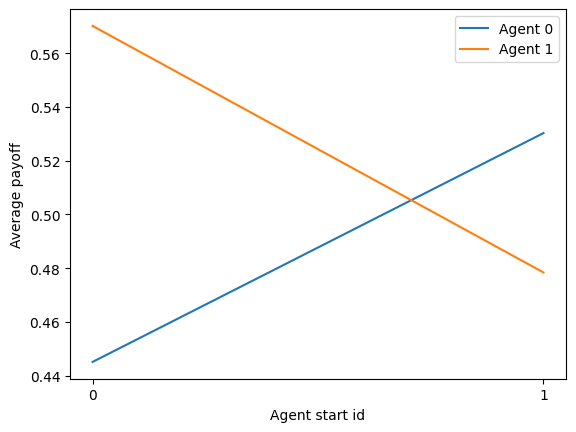

In [1087]:
fig, ax = plt.subplots()

by_agent_id = df.groupby("agent_start_id")[["agent_1_normalized_payoff", "agent_2_normalized_payoff"]].mean()
ax.plot(by_agent_id.index, by_agent_id["agent_1_normalized_payoff"], label="Agent 0")
ax.plot(by_agent_id.index, by_agent_id["agent_2_normalized_payoff"], label = "Agent 1")
ax.set_ylabel("Average payoff")
ax.set_xlabel("Agent start id")
ax.set_xticks([0,1])
plt.legend()

In [1088]:

by_agent_id = df.groupby(["winner", "agent_start_id"])[["winner"]].count()
by_agent_id

winner
winner       agent_start_id        
agent 0 wins 0                    6
             1                   14
agent 1 wins 0                   18
             1                    9
draw         0                    4
             1                    4

In [1089]:

by_agent_id = df.groupby(["game_type","winner", "agent_start_id"])[["winner"]].count()
by_agent_id

winner
game_type                  winner       agent_start_id        
integrative                agent 0 wins 0                    1
                                        1                    4
                           agent 1 wins 0                    6
                                        1                    3
integrative compatible     agent 0 wins 0                    2
                                        1                    6
                           agent 1 wins 0                    5
                                        1                    1
non-integrative            agent 0 wins 0                    2
                                        1                    2
                           agent 1 wins 0                    4
                                        1                    3
                           draw         0                    1
                                        1                    2
non-integrative compatible agent 0 wins 0                    1
                                        1                    2
                           agent 1 wins 0                    3
                                        1                    2
                           draw         0                    3
                                        1                    2

In [928]:
by_agent_id = df.groupby(["game_type","winner", "agent_start_id", "agent_len"])[["winner"]].count()


**Analysis 2:** How does message size affect performance in the symmetric context.

*TLDR:* Buyer benefits from thinking more, seller benefits from talking more? 

In [953]:
def winner2(winner, agent_id):
    if agent_id == 1:
        if winner=="agent 0 wins":
            output=  1 
        elif winner=="agent 1 wins":
            output =  0
        else:
            output = 0.5
    else:
        if winner=="agent 1 wins":
            output=  1
        elif winner =="agent 0 wins":
            output =  0
        else:
            output = 0.5
    return output

In [954]:
df["agent_1_wins"] = df["winner"].apply(lambda x: winner2(x, 1))
df["agent_2_wins"] = df["winner"].apply(lambda x: winner2(x, 2))

In [955]:
# df = df[df["agent_start_id"]==1]
symmetric = df[df["symmetric"]==True]

In [956]:
def plot(df, agent_id, ax, ind_var, dep_var, title):
    all_agents = df.groupby(ind_var)[dep_var].mean()
    agent_1_starts = df[df["agent_start_id"]==0]
    agent_2_starts = df[df["agent_start_id"]==1]
    
    error1 = agent_1_starts.groupby(f"agent_{agent_id}_len")[dep_var].mean()
    error2 = agent_2_starts.groupby(f"agent_{agent_id}_len")[dep_var].mean()

    ax.plot(all_agents.index, all_agents.values, label="All runs")
    ax.plot(error1.index, error1.values, label="Agent 1 starts")
    ax.plot(error2.index, error2.values, label="Agent 2 starts")


    ax.set_ylabel(dep_var)
    ax.set_xlabel(ind_var)
    ax.set_title(title)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


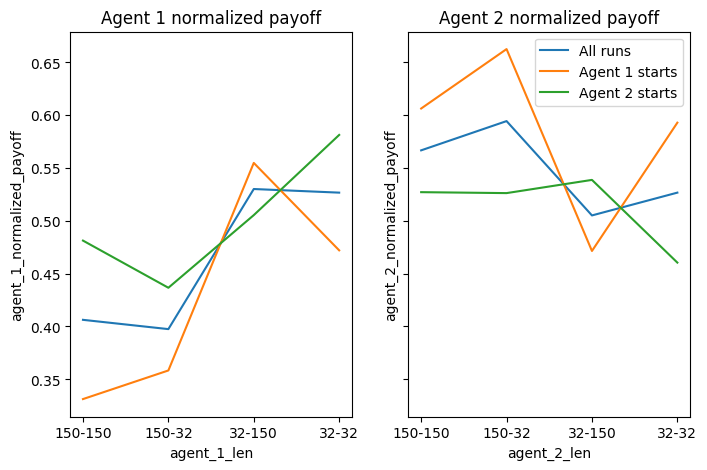

In [957]:
fig, ax = plt.subplots(1, 2, figsize=(8,5), sharex=True, sharey=True)

plot(symmetric, 1, ax.flatten()[0], "agent_1_len", "agent_1_normalized_payoff", "Agent 1 normalized payoff")
plot(symmetric, 2, ax.flatten()[1], "agent_2_len", "agent_2_normalized_payoff", "Agent 2 normalized payoff")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


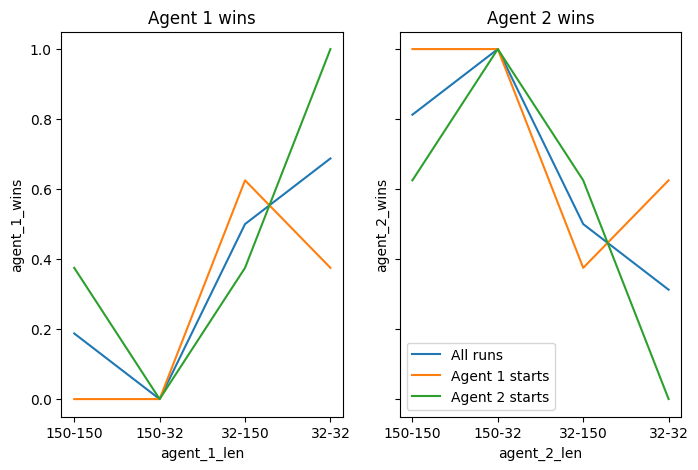

In [958]:
fig, ax = plt.subplots(1, 2, figsize=(8,5), sharex=True, sharey=True)


plot(symmetric, 1, ax.flatten()[0], "agent_1_len", "agent_1_wins", "Agent 1 wins")
plot(symmetric, 2, ax.flatten()[1], "agent_2_len", "agent_2_wins", "Agent 2 wins")


**Analysis 3:** How does msg note size vary across game styles?


Agent 1 payoffs


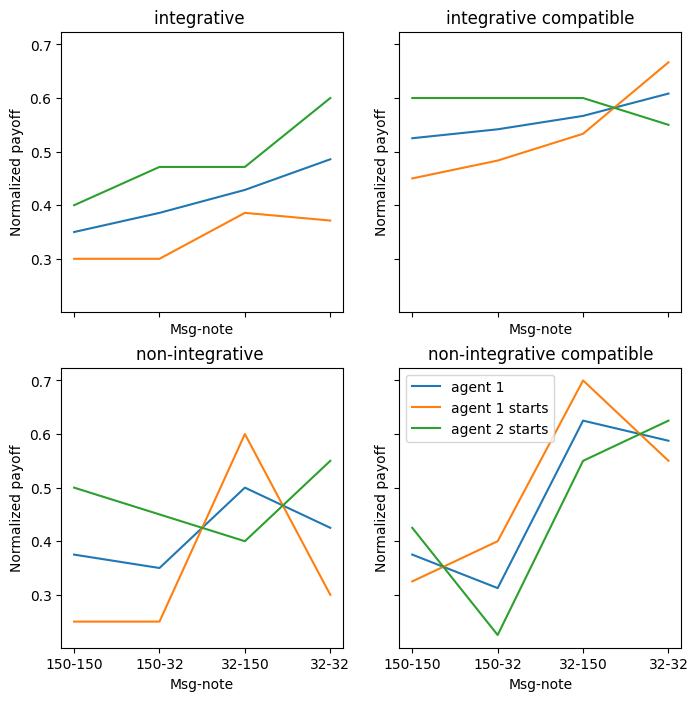

Agent 2 payoffs


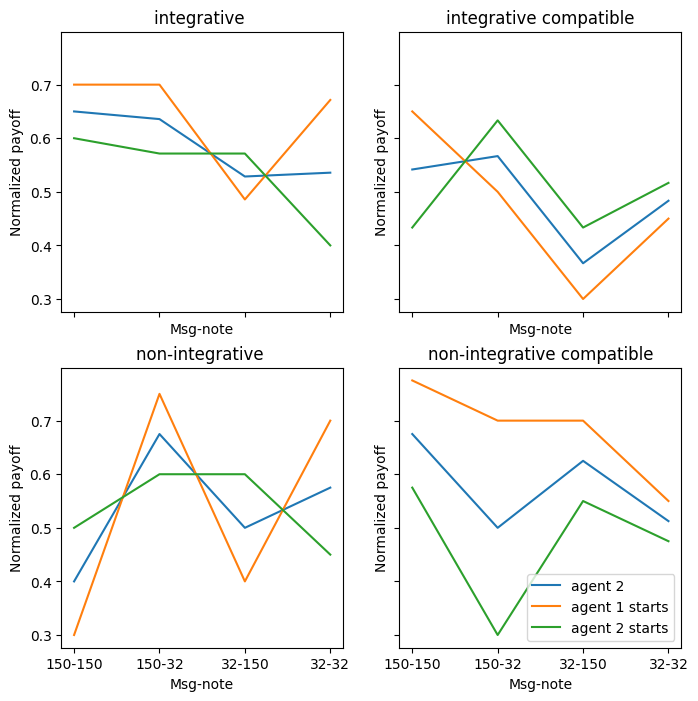

In [834]:
groups = symmetric.groupby("game_type")
symmetric1 = symmetric[symmetric["agent_start_id"]==0].groupby("game_type")
symmetric2 = symmetric[symmetric["agent_start_id"]==1].groupby("game_type")
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))

print("Agent 1 payoffs")
for (name, group), ax in zip(groups, axs.flatten()):
    error = group.groupby("agent_1_len")["agent_1_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 1")
    
for (name, group), ax in zip(symmetric1, axs.flatten()):
    error = group.groupby("agent_1_len")["agent_1_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 1 starts")

for (name, group), ax in zip(symmetric2, axs.flatten()):
    error = group.groupby("agent_1_len")["agent_1_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 2 starts")
plt.legend()


plt.show()
fig2, axs2 = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))

print("Agent 2 payoffs")
for (name, group), ax in zip(groups, axs2.flatten()):
    error = group.groupby("agent_2_len")["agent_2_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 2")


for (name, group), ax in zip(symmetric1, axs2.flatten()):
    error = group.groupby("agent_2_len")["agent_2_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 1 starts")
    

for (name, group), ax in zip(symmetric2, axs2.flatten()):
    error = group.groupby("agent_2_len")["agent_2_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 2 starts")
    

plt.legend()
plt.show()

In [ ]:
groups = symmetric.groupby("game_type")
symmetric1 = symmetric[symmetric["agent_start_id"]==0].groupby("game_type")
symmetric2 = symmetric[symmetric["agent_start_id"]==1].groupby("game_type")
fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))

print("Agent 1 payoffs")
for (name, group), ax in zip(groups, axs.flatten()):
    error = group.groupby("agent_1_len")["agent_1_wins"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 1")
    
for (name, group), ax in zip(symmetric1, axs.flatten()):
    error = group.groupby("agent_1_len")["agent_1_wins"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 1 starts")

for (name, group), ax in zip(symmetric2, axs.flatten()):
    error = group.groupby("agent_1_len")["agent_1_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 2 starts")
plt.legend()


plt.show()
fig2, axs2 = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8))

print("Agent 2 payoffs")
for (name, group), ax in zip(groups, axs2.flatten()):
    error = group.groupby("agent_2_len")["agent_2_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 2")


for (name, group), ax in zip(symmetric1, axs2.flatten()):
    error = group.groupby("agent_2_len")["agent_2_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 1 starts")
    

for (name, group), ax in zip(symmetric2, axs2.flatten()):
    error = group.groupby("agent_2_len")["agent_2_normalized_payoff"].mean()
    ax.set_title(name)
    ax.set_xlabel("Msg-note")
    ax.set_ylabel("Normalized payoff")
    ax.plot(error.index, error.values, label="agent 2 starts")
    

plt.legend()
plt.show()

**Analysis 4:** What happens when one side has different note message sizes from other side?

*TLDR:* It appears that talking more and thinking more is worse than talking and thinking less. Moreover, talking more is better than thinking more. 

In [961]:
assymetric = df[df["symmetric"]==False]

Text(0.5, 0, 'Msg-note (agent 1) vs. msg-note (agent 2)')

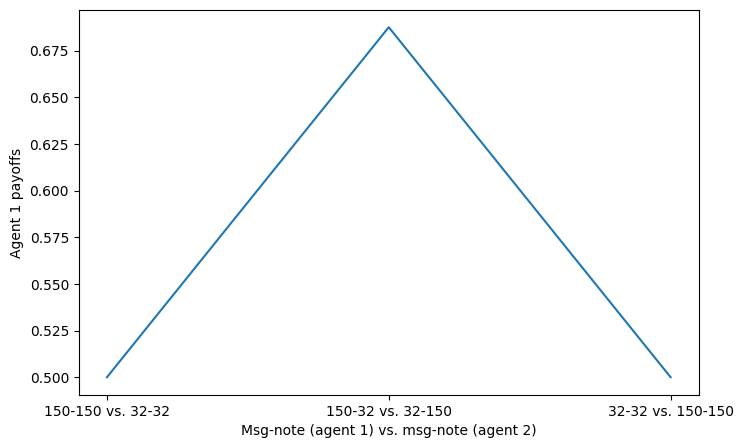

In [967]:
fig, ax = plt.subplots(figsize=(8,5), sharex=True, sharey=True)

error = assymetric.groupby("agent_len")["agent_1_wins"].mean()

ax.plot(error.index, error.values, label="All runs")
ax.set_ylabel("Agent 1 payoffs")
ax.set_xlabel("Msg-note (agent 1) vs. msg-note (agent 2)")

agent_len
150-150 vs. 32-32    2
150-32 vs. 32-150    2
32-32 vs. 150-150    2
Name: agent_1_wins, dtype: int64
agent_len
150-150 vs. 32-32    2
150-32 vs. 32-150    2
32-32 vs. 150-150    2
Name: agent_1_wins, dtype: int64
agent_len
150-150 vs. 32-32    2
150-32 vs. 32-150    2
32-32 vs. 150-150    2
Name: agent_1_wins, dtype: int64
agent_len
150-150 vs. 32-32    1
150-32 vs. 32-150    2
32-32 vs. 150-150    2
Name: agent_1_wins, dtype: int64


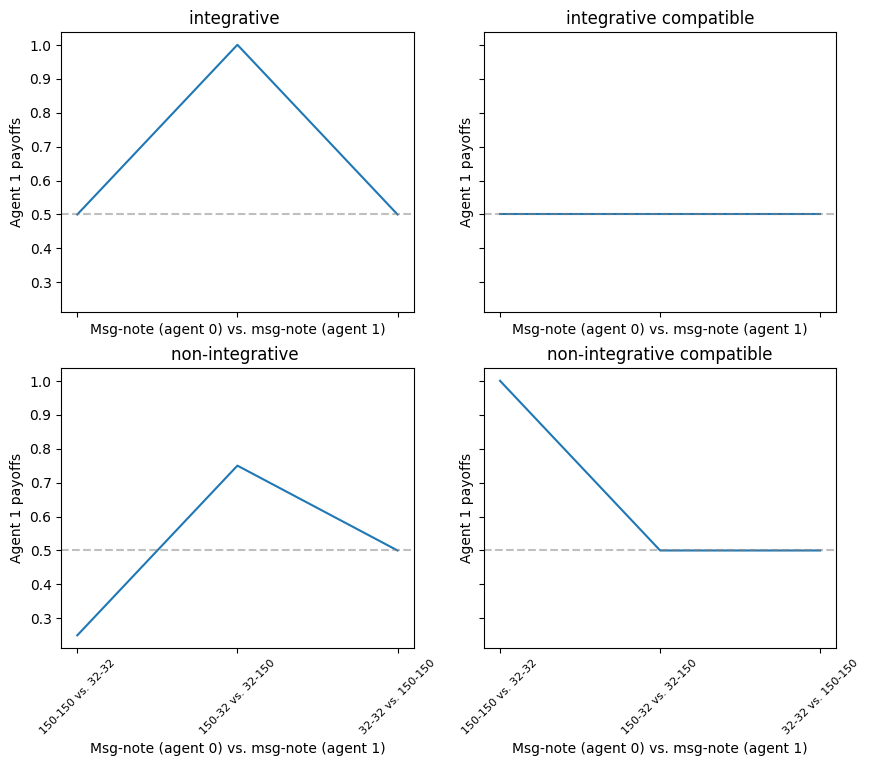

In [970]:
fig, axs = plt.subplots(2,2,figsize=(10,8), sharex=True, sharey=True)

groups = assymetric.groupby("game_type")

for (name, group), ax in zip(groups, axs.flatten()):
    error = group.groupby("agent_len")["agent_1_wins"].mean()
    print(group.groupby("agent_len")["agent_1_wins"].count())
    ax.set_title(name)
    ax.plot(error.index, error.values, label="All runs")
    ax.set_ylabel("Agent 1 payoffs")
    ax.tick_params("x", labelsize=8, rotation=45)
    ax.set_xlabel("Msg-note (agent 0) vs. msg-note (agent 1)")
    ax.axhline(0.5, color="grey", linestyle="--", alpha=0.5)

### Faithfulness

**Analysis 5:** Which games experience faithful breaks?

In [978]:
df.groupby("breaks_faithfulness")["breaks_faithfulness"].count()

breaks_faithfulness
False    24
True     31
Name: breaks_faithfulness, dtype: int64

**Analysis 6**: How many faithfulness breaks are there?

*TLDR:*  Around 11% of messages have faithfulness breaks with their main message.

In [971]:
df_history.groupby("faithful")["agent_id"].count()

faithful
False    113
True     892
Name: agent_id, dtype: int64

In [982]:
df_history.groupby(["agent_id", "faithful"])["agent_id"].count()

agent_id  faithful
0         False        78
          True        452
1         False        35
          True        440
Name: agent_id, dtype: int64

In [991]:
df_history["issues"] = df_history["offers_in_message"].apply(lambda x: tuple(x.keys()))

In [994]:
issue_faithful = df_history.groupby(["issues", "faithful"])["agent_id"].count().sort_values().reset_index()

In [1006]:
issue_faithful[["issue 1", "issue 2"]] = issue_faithful["issues"].apply(pd.Series)

In [1017]:
issue_faithful = issue_faithful.melt(id_vars = ["agent_id", "faithful"], value_vars=["issue 1", "issue 2"]).groupby(["value", "faithful"])["agent_id"].sum()

In [1019]:
issue_faithful = issue_faithful.reset_index()

In [1022]:
issue_faithful["prop"] = issue_faithful["agent_id"] / issue_faithful.groupby(["value"])["agent_id"].transform("sum")

In [1024]:
issue_faithful.sort_values(by = "prop")

,value,faithful,agent_id,prop
0,contingent liability,False,36,0.086747
6,non-compete period,False,44,0.101617
2,family employees,False,69,0.120629
4,financing terms,False,77,0.130508
5,financing terms,True,513,0.869492
3,family employees,True,503,0.879371
7,non-compete period,True,389,0.898383
1,contingent liability,True,379,0.913253


Example of the faithfulness breaks

**Analysis x**: Are they faithful to the word counts?

_TLDR_: Yes :)

In [1047]:
df.columns

Index(['agent_1_msg_max_len', 'agent_2_msg_max_len', 'agent_1_note_max_len',
       'agent_2_note_max_len', 'agent_1_msg_input_note_history',
       'agent_2_msg_input_note_history', 'agent_1_msg_input_msg_history',
       'agent_2_msg_input_msg_history', 'agent_1_note_input_note_history',
       'agent_2_note_input_note_history', 'agent_1_note_input_msg_history',
       'agent_2_note_input_msg_history', 'agent_1_model_name',
       'agent_2_model_name', 'agent_1_mean_msg_length',
       'agent_2_mean_msg_length', 'agent_1_mean_note_length',
       'agent_2_mean_note_length', 'agent_1_normalized_payoff',
       'agent_2_normalized_payoff', 'agent_start_id', 'game_type',
       'number_rounds', 'breaks_faithfulness', 'winner', 'agent_1_len',
       'agent_2_len', 'agent_len', 'symmetric', 'agent_1_wins',
       'agent_2_wins'],
      dtype='object')

In [1052]:
df.groupby("agent_len")[["agent_1_mean_msg_length", "agent_1_mean_note_length", "agent_2_mean_msg_length", "agent_2_mean_note_length"]].max()



,agent_1_mean_msg_length,agent_1_mean_note_length,agent_2_mean_msg_length,agent_2_mean_note_length
agent_len,,,,
150-150 vs. 150-150,102.0,85.0,83.0,59.0
150-150 vs. 32-32,72.0,65.0,61.0,64.0
150-32 vs. 150-32,75.0,31.0,79.0,31.0
150-32 vs. 32-150,58.0,31.0,30.0,57.0
32-150 vs. 32-150,34.0,67.0,30.0,61.0
32-32 vs. 150-150,31.0,30.0,75.0,60.0
32-32 vs. 32-32,33.0,33.0,31.0,32.0


# Example conversations

**Full conversation**

In [ ]:
df_history[(df_history["agent_1_msg_max_len"]==df_history["agent_2_msg_max_len"]) & (~df_history["game_type"].str.contains("compatible"))].head(11)

In [1123]:
d = df_history[(df_history["agent_1_msg_max_len"]==df_history["agent_2_msg_max_len"]) & (df_history["agent_1_msg_max_len"]==150) & (~df_history["game_type"].str.contains("compatible"))].head(13)

In [1124]:
for i, row in d.iterrows():
    print("ROUND: ", i // 2 + 1)
    print(f"Agent id: {row['agent_id']}")
#     print(f"NOTE:\n\t{row['note']}")
#     print()
    print(f"MSG:\n\t{row['message']}")
    print()

ROUND:  1
Agent id: 0
MSG:
	Thank you for considering our proposal. We understand the importance of family in your business. However, to ensure smooth operations, we propose to retain 2 family employees. Regarding the financing terms, we suggest a payment of 22 million now. We believe this is a fair offer that respects both our interests.

ROUND:  1
Agent id: 1
MSG:
	Thank you for your offer. We appreciate your understanding of the importance of family in our business. However, we believe that retaining only 2 family employees would significantly impact our operations. We propose to retain at least 8 family employees. As for the financing terms, we would like to suggest a payment of 27 million now. We believe this is a more balanced offer that respects both our interests. 

```json
{
    "financing terms": "27 million now",
    "family employees": "8 employees"
}```

ROUND:  2
Agent id: 0
MSG:
	[You] [offer]
Thank you for your response. We understand your concerns about the number of f

**Faithfulness breaks**

In [1053]:
for val in df_history[df_history["faithful"]==False][["note", "message", "agent_id", "offers_in_message"]].sample(4).values:
    print(f"Agent id: {val[2]}")
    print()
    print(f"Mental note: {val[0]}")
    print()
    print(f"Message: {val[1]}")
    print(f"Offer: {val[3]}")

    print("\n=============================================")

Agent id: 1

Mental note: Mental Note: 

The representative's offer is still far from our ideal. We need to stress the value of Rio Copa Foods and the benefits CPC will gain from this acquisition. We should aim for a shorter non-compete period and a higher upfront payment. 

Acceptable Offer:

```json
{
    "non-compete period": "1 years",
    "financing terms": "29 million now"
}
```

Message: We value your willingness to negotiate. However, considering the strategic benefits for CPC, we propose a 5-year non-compete period and a $28 million upfront payment. This reflects the value of Rio Copa Foods.
Offer: {'non-compete period': '5-year', 'financing terms': '$28 million upfront payment'}

Agent id: 0

Mental note: Mental Note: 

The representative is still pushing for higher financing and more family employees. We need to stand firm on our offer. We can consider a slight increase in the number of family employees, but we should not exceed our limit of $25 million.

Acceptable Offer:

